# Определение токсичности текста

Целью работы было создание базовой модели классификации текстов, попутно включающей элементы текстового анализа. 

Может быть полезно:

[«Люблю» и «ненавижу»: анализ эмоциональной окраски текста с помощью Python](https://proglib.io/p/lyublyu-i-nenavizhu-analiz-emocionalnoy-okraski-teksta-s-pomoshchyu-python-2020-11-13)

[Определение токсичных комментариев на русском языке](https://habr.com/ru/company/vk/blog/526268/)

[Deep Learning vs common sense: разрабатываем чат-бота](https://habr.com/ru/company/oleg-bunin/blog/455652/)

[Сентимент-анализ. Определяем эмоциональные сообщения на Хабре](https://habr.com/ru/company/simbirsoft/blog/539508/)

## 1. Загрузка библиотек

In [ ]:
#pip install pymorphy2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

import re
import pickle
import pymorphy2
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

## 2. Загрузка данных

Данные с платформы [kaggle](https://www.kaggle.com/blackmoon/russian-language-toxic-comments)

In [2]:
toxic_comments = pd.read_csv('data/labeled.csv')
toxic_comments.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [3]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


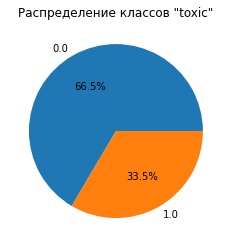

In [4]:
toxic_comments['toxic'].value_counts().plot(kind='pie', title='Распределение классов "toxic"', autopct='%1.1f%%')
plt.axis('off')
plt.show()

В данных всего 14412 примера и отсутсвуют пропуски. Целевая переменная `toxic` имеет дисбаланс классов, в связи с этим при оценки модели будем ориентироваться на метрики *F1*, *precision* и *recall*.

## 3. Предобработка текста

### 3.1 Токенизация

[nltk: стемминг](https://www.nltk.org/api/nltk.stem.snowball.html)

[лемматизация](https://python-school.ru/blog/nlp-text-preprocessing/)

In [5]:
TOKEN_RE = re.compile(r'[а-яё]+')
russian_stopwords = stopwords.words("russian")
lemmatizer = pymorphy2.MorphAnalyzer()

In [6]:
def tokenize_text(txt, min_lenght_token=2):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_lenght_token]

def remove_stopwords(tokens):
    return list(filter(lambda token: token not in russian_stopwords, tokens))

def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(txt):
    tokens = tokenize_text(txt)
    tokens = remove_stopwords(tokens)
    tokens  = lemmatizing(tokens)
    return ' '.join(tokens)
   

In [7]:
tqdm.pandas()

df_token = toxic_comments.copy()
df_token['comment'] = df_token['comment'].progress_apply(text_cleaning)
df_token.head()

100%|███████████████████████████████████| 14412/14412 [01:20<00:00, 178.28it/s]


,comment,toxic
0,верблюд дебил бл,1.0
1,хохол это отдушина затюканый россиянин мол вон...,1.0
2,собака собачий смерть,1.0
3,страница обновить дебил это оскорбление доказа...,1.0
4,убедить страничный пдф скрипаль отравить росси...,1.0


### 3.2 Дубликаты

Проверим появились ли пустые тексты после токенизации и удалим их, если они есть

In [8]:
df = df_token.copy()
empty = df[df['comment'] == '']
print('Количество пустых тескстов:', len(empty))
df = df.drop(empty.index)

Количество пустых тескстов: 12


Проверим данные на наличие дубликатов

In [9]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 222


После небольшого анализа выяснилось, что после очистки текста одной из причин появления дубликатов было наличие примеров  в исходных данных отличающиеся только символом `\n`. Такие дубликаты можно легко удалить

In [10]:
df = df.drop_duplicates()

Проверим комменатрии на наличие дубликатов 

In [11]:
print('Количество повторяющихся комментариев:', df['comment'].duplicated().sum())

Количество повторяющихся комментариев: 45


Данный факт свидетельсвует о неоднозначности метки токсичности.

Случаи неоднозначности:
1. Исходные комментарии одинаковые, а метки разные
2. Исходные комментарии разные, но после токенизации стали одинаковыми, при этом метки разные

Прмер 1 случая

In [12]:
df[df['comment'] == 'маска лицо жать']

,comment,toxic
1084,маска лицо жать,0.0
5487,маска лицо жать,1.0


In [13]:
# исходный текст
toxic_comments.loc[[1084, 5487]]

,comment,toxic
1084,"После маски,лицо жмет",0.0
5487,"После маски,лицо жмет\n",1.0


Прмер 2 случая

In [14]:
df[df['comment'] == 'год']

,comment,toxic
6044,год,1.0
9803,год,0.0


In [15]:
# исходный текст
toxic_comments.loc[[6044, 9803]]

,comment,toxic
6044,она уже там лет 15!!!!!!\n,1.0
9803,Лет 50 ничего им не будет\n,0.0


Посмотрим на все дубликаты в комментариях

In [16]:
comment_duplicated = df[df['comment'].duplicated('last')]
comment_duplicated

,comment,toxic
127,ночной большевистский обострение,1.0
158,это свой мама сестра родный утро,1.0
358,писечка поперёк это мама передаться,1.0
540,просто социальный несправедливость давать поко...,0.0
660,осторожный увидеть писать переести нога,1.0
954,истинно мрия жидов вертеть шарик несколько тыс...,0.0
1084,маска лицо жать,0.0
1145,чушь отделить кто отделить,1.0
1151,хэллоуин год шлак полный оценка,1.0
1160,алгоритм блядь отправить жалоба бан модератор ...,0.0


In [17]:
# удалим дубликаты в комментариях
df = df.drop_duplicates(subset='comment')

# Проставим метки для примеров 
zero_labels = [1084, 1198, 1250, 1394, 1456, 1586, 1631, 1637, 1659, 
               1693, 1703, 1739, 1781, 1814, 1820, 1877, 4256, 6044]
for row in comment_duplicated.iterrows():
    comment = row[1]['comment']
    idx = df[df['comment'] == comment].index
    if idx in zero_labels:
        label = 0.
    else:
        label = 1.
    df.loc[idx, 'toxic'] = label
    
print('Количество дубликатов:', df.duplicated('comment').sum())    

Количество дубликатов: 0


In [18]:
df.to_csv('clean_lemma_text3.csv', index=False)

In [19]:
clean_text = pd.read_csv('clean_lemma_text3.csv')
clean_text

,comment,toxic
0,верблюд дебил бл,1.0
1,хохол это отдушина затюканый россиянин мол вон...,1.0
2,собака собачий смерть,1.0
3,страница обновить дебил это оскорбление доказа...,1.0
4,убедить страничный пдф скрипаль отравить росси...,1.0
...,...,...
14128,один исключать другой ненавидеть быть любой сл...,1.0
14129,принимать участие опрос сказать доверять путин...,0.0
14130,мочь вертухай ссаколов собрать столько порядоч...,1.0
14131,тасс март премьер министр новый зеландия джаси...,0.0


## 4. Частотный анализ

[Частотный анализ русского текста и облако слов на Python](https://habr.com/ru/post/517410/)

In [20]:
# Подсчет встречаемости каждого слова в корпусе
corpus = clean_text['comment'].values

text = ' '.join(corpus)
counter = Counter(text.split())
sorted_counter = counter.most_common()
sorted_counter[:5]

[('это', 4031),
 ('год', 1515),
 ('такой', 1438),
 ('который', 1406),
 ('человек', 1101)]

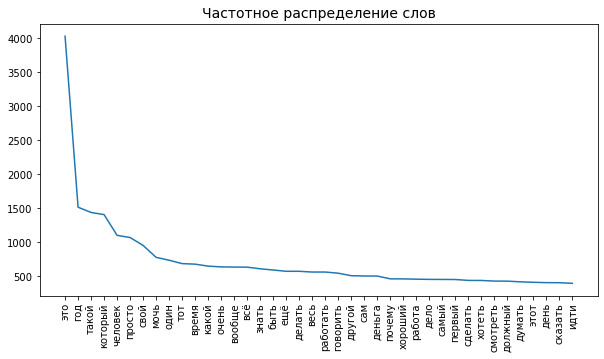

In [21]:
# Отрисовка графика частнотности слов
words = [pair[0] for pair in sorted_counter]
words_count = [pair[1] for pair in sorted_counter]

plt.figure(figsize=(10, 5))
plt.plot(words[:40], words_count[:40])
plt.xticks(rotation=90)
plt.title('Частотное распределение слов', fontsize=14)
plt.show()

Для каждого класса токсичности создадим "облако слов"

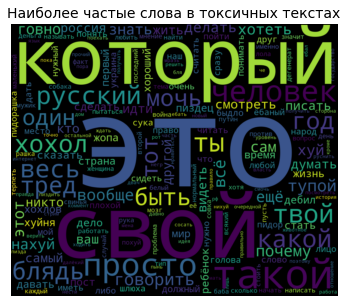

In [22]:
only_toxic = clean_text[clean_text['toxic'] == 1]
text_toxic = ' '.join(only_toxic['comment'].values)

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_toxic)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Наиболее частые слова в токсичных текстах', fontsize=14)
plt.show()

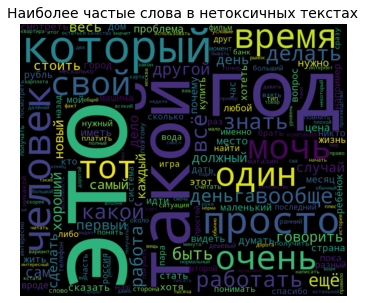

In [23]:
notoxic = clean_text[clean_text['toxic'] == 0]
norm_text = ' '.join(notoxic['comment'].values)

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(norm_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Наиболее частые слова в нетоксичных текстах', fontsize=14)
plt.show()

Слова "это" и "всё" самые встречаемые слова в обоих классах. При классиффикации они не будут нести значимой информации для определения правильного класса. Далее в `TfidfVectorizer` установим ограничение `max_df`.

## 5. Векторизация

In [24]:
RANDOM_STATE = 311
df_train, df_test = train_test_split(clean_text, 
                                     random_state=RANDOM_STATE, 
                                     test_size=0.2, 
                                     stratify=clean_text['toxic']
                                    )

train_corpus = df_train['comment'].values
test_corpus = df_test['comment'].values

y_train = df_train['toxic']
y_test = df_test['toxic']

In [124]:
vectorizer = TfidfVectorizer(ngram_range=(2,4), analyzer='char_wb', max_df=0.8, min_df=10)
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

print('Всего признаков:', len(vectorizer.get_feature_names()))

Всего признаков: 16576


## 6. Baseline. Логистическая регрессия

[Пошаговое построение логистической регрессии в Python](https://medium.com/nuances-of-programming/%D0%BF%D0%BE%D1%88%D0%B0%D0%B3%D0%BE%D0%B2%D0%BE%D0%B5-%D0%BF%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BB%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9-%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8-%D0%B2-python-a7c650ae77c2)

[5 главных алгоритмов сэмплинга](https://habr.com/ru/post/461285/)

[SMOTE](https://towardsdatascience.com/smote-fdce2f605729)

In [125]:
Logregres = LogisticRegression(max_iter=10000, random_state=42, C=3, solver='liblinear')
Logregres.fit(X_train, y_train)
y_pred = Logregres.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93      1883
         1.0       0.90      0.78      0.84       944

    accuracy                           0.90      2827
   macro avg       0.90      0.87      0.88      2827
weighted avg       0.90      0.90      0.90      2827



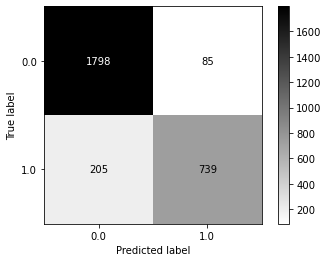

In [126]:
plot_confusion_matrix(Logregres, X_test, y_test, cmap='binary')
plt.show()

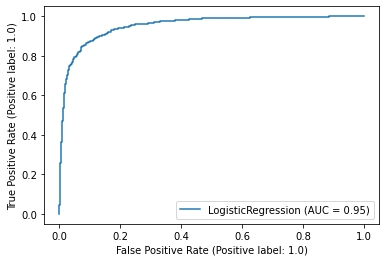

In [127]:
plot_roc_curve(Logregres, X_test, y_test)
plt.show()

In [128]:
full_corpus = clean_text['comment'].values
y = clean_text['toxic'].values

final_vectorizer = TfidfVectorizer(ngram_range=(2,4), analyzer='char_wb', max_df=0.8, min_df=10)
X_full = final_vectorizer.fit_transform(full_corpus)

final_model = LogisticRegression(max_iter=10000, random_state=42, C=3, solver='liblinear').fit(X_full, y)

In [131]:
with open('toxic_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [132]:
with open('toxic_vectorizer.pkl', 'wb') as f:
    pickle.dump(final_vectorizer, f)

## 7. Проверка модели

In [133]:
def bot():
    while True:
        message = input('Ввод: ')
        if message == '0':
            break
        clean_text = text_cleaning(message)
        X_example = final_vectorizer.transform([clean_text])
        toxic_propabality = final_model.predict_proba(X_example)[0,1]
        print(f'Вероятность токсичности: {toxic_propabality:.2f}')

In [134]:
bot()

Ввод: привет, друг
Вероятность токсичности: 0.17
Ввод: Тупой бот
Вероятность токсичности: 1.00
Ввод: Отличный пример отсутствия мозга
Вероятность токсичности: 0.60
Ввод: 0


Дополнительно:

[From Word Embeddings to Pretrained Language Models — A New Age in NLP — Part 2](https://towardsdatascience.com/from-word-embeddings-to-pretrained-language-models-a-new-age-in-nlp-part-2-e9af9a0bdcd9)

[Learn how to build powerful contextual word embeddings with ELMo](https://medium.com/saarthi-ai/elmo-for-contextual-word-embedding-for-text-classification-24c9693b0045)

[Neural Network Embeddings Explained](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526)

Что еще можно сделать:
+ Уравнять количество примеров каждого класса (SMOTE)
+ Применить нейросеть (CNN, LSTM)